In [2]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ops.wipe()
ops.model('Basic','-ndm',2,'-ndf',3)

In [4]:
#data in SI
gap = 0.003
m1 = 75*10**3
m2 = 3000*10**3
T1 = 1.2
T2 = 0.3
c1 = 39270
c2 = 6.283*10**6
k1 = 2.056*10**6
k2 = 1.316*10**9
#damping ratio-->dr
dr1 = 0.05
dr2 = 0.05
E = 2*10**11
h1 = 5
bay = 4

In [5]:
#model creation
ops.node(1,0,0)
ops.node(2,bay,0)
ops.node(3,0,h1)
ops.node(4,bay,h1)
ops.fix(1,1,1,1)
ops.fix(2,1,1,1)
ops.equalDOF(3,4,2,3)# shear beam

In [6]:
ops.mass(3,0.5*m1)
ops.mass(4,0.5*m1)

In [7]:
Ic1 = k1/2*h1**3/(24*E)
Ib1 = Ic1
A1 = np.sqrt((12*Ic1))

In [8]:
a = 0.35
transftag = 1
ops.uniaxialMaterial('ViscousDamper',1,k1,c1,a)
ops.geomTransf('Linear',transftag)
ops.element('elasticBeamColumn',1,1,3,A1,E,Ic1,transftag)
ops.element('elasticBeamColumn',2,2,4,A1,E,Ic1,transftag)
ops.element('elasticBeamColumn',3,3,4,A1,E,Ib1,transftag)
#damper
ops.element('twoNodeLink',4,1,4,'-mat',1,'-dir',1)


ViscousDamper Model by Sarven Akcelyan and Dimitrios G. Lignos, PhD, McGill University


In [9]:
ops.node(5,bay+gap,0)
ops.node(6,bay*2+gap,0)
ops.node(7,bay+gap,h1)
ops.node(8,bay*2+gap,h1)
ops.fix(5,1,1,1)
ops.fix(6,1,1,1)
ops.equalDOF(7,8,2,3)

In [10]:
ops.mass(7,0.5*m2)
ops.mass(8,0.5*m2)

In [11]:
Ic2 = k2/2*h1**3/(24*E)
Ib2 = Ic2
A2 = np.sqrt((12*Ic2))

In [12]:
ops.uniaxialMaterial('ViscousDamper',1000,k2,c2,a)
ops.element('elasticBeamColumn',5,5,7,A2,E,Ic2,transftag)
ops.element('elasticBeamColumn',6,6,8,A2,E,Ic2,transftag)
ops.element('elasticBeamColumn',7,7,8,A2,E,Ib2,transftag)
#damper
ops.element('twoNodeLink',8,5,8,'-mat',1000,'-dir',1)

In [13]:
ops.rayleigh(0.01,0.02,0,0)

<AxesSubplot: >

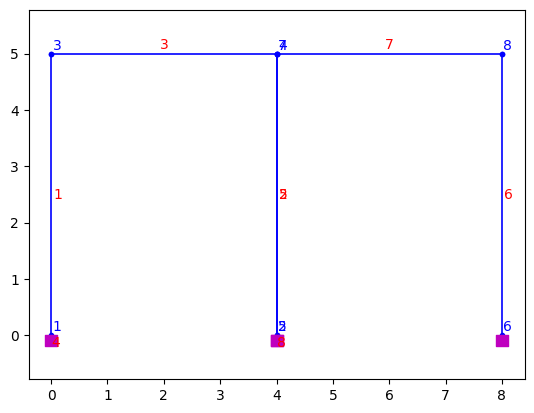

In [14]:
ovs.plot_model()

In [15]:
#kelvin voigt model
ops.node(9,bay,h1)
viscousID = 2
alpha = 1
ops.uniaxialMaterial('Viscous', viscousID, c2, alpha)
springID = 3
Fy = 250 * 10**6
E0 = 93500 * 10**3
b = 0.1
ops.uniaxialMaterial('Steel01', springID, Fy, E0, b)
eppGAPMatID = 4
E = 2* E0
Fy = 250*10**6
ops.uniaxialMaterial('ElasticPPGap', eppGAPMatID, 1*E, -1*Fy, -1*gap, 0.1)
parallelTag = 100
ops.uniaxialMaterial('Parallel', parallelTag, *[viscousID, springID])
ops.element('zeroLength', 101, *[4,9], '-mat', parallelTag, '-dir', *[1])
ops.element('twoNodeLink',102,*[9,7],'-mat',eppGAPMatID,'-dir',*[1])

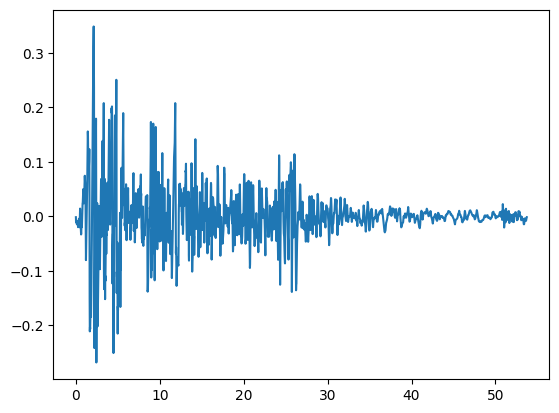

In [16]:
ground_motion = np.loadtxt('elcentro.txt',delimiter = " ")
plt.plot(ground_motion[:,0],ground_motion[:,1])
dt = ground_motion[:,0][1]

In [17]:
ops.timeSeries('Path', 1, '-dt', dt, '-values', *ground_motion[:,1], '-fact', 9.81)
ops.pattern('UniformExcitation', 200, 1, '-accel', 1)

In [18]:
#testing
ops.equalDOF(4,9,2,3)

In [19]:
eqLoad = 2
# ops.timeSeries('Path', eqLoad, '-dt', 0.01, '-filePath', "TakY.th", '-factor', g)
# ops.pattern('UniformExcitation', eqLoad, 1, '-accel', eqLoad)
# recorders

ops.recorder('Node', '-file', 'left_corner.txt', '-time', '-closeOnWrite','-node',4 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'right_corner.txt', '-time', '-closeOnWrite','-node',7 , '-dof', 1, 'disp')
#ops.recorder('Element', '-file', 'eppDisplacement.txt', '-time', '-closeOnWrite','-ele',1 , '-dof', 1, 'deformation')
ops.recorder('Element', '-file', 'Reactions_EPP.txt', '-time', '-closeOnWrite','-ele',101 , '-dof', 1, 'force')
ops.recorder('Element', '-file', 'Reactions_KV.txt', '-time', '-closeOnWrite','-ele',102 , '-dof', 1, 'force')

# analysis

ops.constraints('Plain')
ops.numberer('RCM')
ops.test('EnergyIncr', 1.0e-10, 100)
ops.algorithm('ModifiedNewton')
ops.system('SparseGEN')
ops.integrator('Newmark', .5, .25)
#ops.integrator('DisplacementControl', 2, 1, 0.001)
ops.analysis('Transient')

In [20]:
TmaxAnalysis = 10
dtAnalysis = 0.01

Nsteps = int(TmaxAnalysis/dtAnalysis)
for i in range(Nsteps):
    ops.analyze(1, dtAnalysis)
    print(f"{(i+1)}/{Nsteps}")


1/1000
2/1000
3/1000
4/1000
5/1000
6/1000
7/1000
8/1000
9/1000
10/1000
11/1000
12/1000
13/1000
14/1000
15/1000
16/1000
17/1000
18/1000
19/1000
20/1000
21/1000
22/1000
23/1000
24/1000
25/1000
26/1000
27/1000
28/1000
29/1000
30/1000
31/1000
32/1000
33/1000
34/1000
35/1000
36/1000
37/1000
38/1000
39/1000
40/1000
41/1000
42/1000
43/1000
44/1000
45/1000
46/1000
47/1000
48/1000
49/1000
50/1000
51/1000
52/1000
53/1000
54/1000
55/1000
56/1000
57/1000
58/1000
59/1000
60/1000
61/1000
62/1000
63/1000
64/1000
65/1000
66/1000
67/1000
68/1000
69/1000
70/1000
71/1000
72/1000
73/1000
74/1000
75/1000
76/1000
77/1000
78/1000
79/1000
80/1000
81/1000
82/1000
83/1000
84/1000
85/1000
86/1000
87/1000
88/1000
89/1000
90/1000
91/1000
92/1000
93/1000
94/1000
95/1000
96/1000
97/1000
98/1000
99/1000
100/1000
101/1000
102/1000
103/1000
104/1000
105/1000
106/1000
107/1000
108/1000
109/1000
110/1000
111/1000
112/1000
113/1000
114/1000
115/1000
116/1000
117/1000
118/1000
119/1000
120/1000
121/1000
122/1000
123/1000
1

In [24]:
left_node=np.loadtxt('left_corner.txt',delimiter = " ")
left_node


array([[ 1.00000e-02,  1.55252e-07],
       [ 2.00000e-02,  8.95219e-07],
       [ 3.00000e-02,  2.60267e-06],
       ...,
       [ 9.98000e+00, -1.23680e-03],
       [ 9.99000e+00, -1.21022e-03],
       [ 1.00000e+01, -1.17945e-03]])

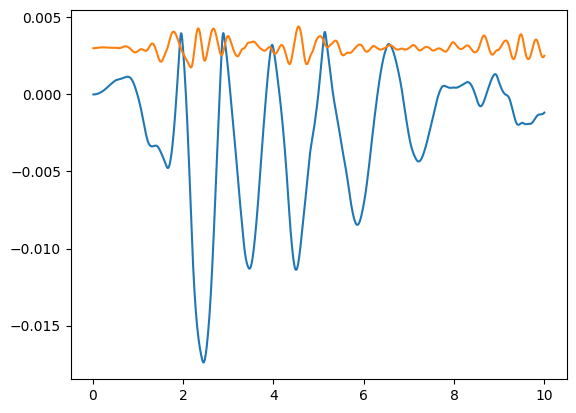

In [22]:
right_node=np.loadtxt('right_corner.txt',delimiter = " ")
test_right_node = []
for i in range(0,len(right_node[:,1])):
    test_right_node.append(gap+right_node[:,1][i])
plt.plot(left_node[:,0],left_node[:,1])
plt.plot(right_node[:,0],test_right_node)


In [393]:
relative_disp = []
for i in range(0,len(left_node[:,1])):
    relative_disp.append(gap-left_node[:,1][i]+right_node[:,1][i])

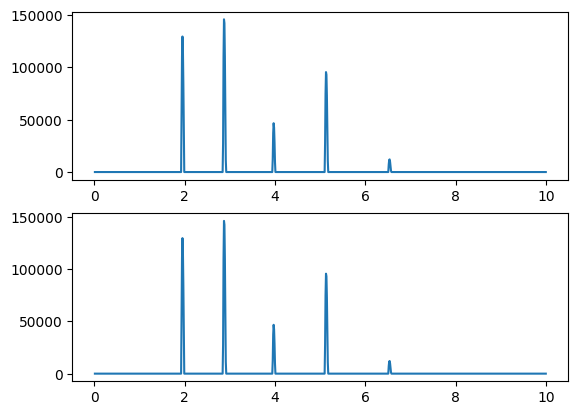

In [394]:
data1=np.loadtxt('Reactions_EPP.txt',delimiter = " ")
data2=np.loadtxt('Reactions_KV.txt',delimiter = " ")
fig,axis = plt.subplots(2,1)
axis[0].plot(data1[:,0],data1[:,1])
axis[1].plot(data2[:,0],data2[:,1])